In [ ]:
'''
Наше приложение это нечто совмещающее новостную ленту и мессенджер, т.е. посты можно лайкать, и 
просматривать, при этом можно обмениваться личными сообщениями.
Соберите отчет по работе всего приложения как единого целого. 
Продумайте, какие метрики необходимо отобразить в этом отчете? Как можно показать их динамику?
Приложите к отчету графики или файлы, чтобы сделать его более наглядным и информативным. 
Отчет должен быть не просто набором графиков или текста, а помогать отвечать бизнесу на вопросы о 
работе всего приложения совокупно. В отчете обязательно должны присутствовать метрики приложения 
как единого целого, или можно отобразить метрики по каждой из частей приложения — по ленте новостей 
и по мессенджеру.
'''

In [ ]:
Код должн с периодичность каждые 15 минут проверять ключевые метрики — такие как 
активные пользователи в ленте / мессенджере, просмотры, лайки, CTR, количество отправленных сообщений.
В случае обнаружения аномального значения, в чат должен отправиться алерт — сообщение со следующей 
информацией: метрика, ее значение, величина отклонения. В сообщение можно добавить дополнительную информацию,
которая поможет при исследовании причин возникновения аномалии. Это может быть, например, график, ссылки
на дашборд/чарт в BI системе. Автоматизируйте систему алертов с помощью Airflow


In [1]:
import pandahouse as ph
# Строка подключения к кликхаус
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20250120',
    'user':'student',
    'password':'dpo_python_2020'}
# Запрос исходной таблицы ленты новостей из БД для понимания структуры таблицы
feed = """
SELECT *
FROM {db}.feed_actions 
WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) < toDate('2025-01-04')"""
# Запрос исходной таблицы мессенджера из БД для понимания структуры таблицы
messenger = """
SELECT *
FROM {db}.message_actions 
WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) < toDate('2025-01-04')"""

In [2]:
# Наша исходная таблица ленты новостей
df_table_feed = ph.read_clickhouse(feed, connection=connection)
df_table_feed.head(5)

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,12827,2004,like,2025-01-03 00:00:00,1,43,Turkey,İzmir,Android,ads,2
1,20565,1942,like,2025-01-03 00:00:00,0,23,Russia,Moscow,iOS,ads,4
2,114053,1915,view,2025-01-03 00:00:00,1,56,Russia,Kirov,Android,organic,3
3,115273,1984,view,2025-01-03 00:00:00,1,21,Russia,Moscow,iOS,organic,3
4,122707,1850,view,2025-01-03 00:00:01,1,25,Russia,Mirnyy,iOS,organic,1


In [3]:
# Наша исходная таблица мессенджера
df_table_messenger = ph.read_clickhouse(messenger, connection=connection)
df_table_messenger.head(5)

,user_id,receiver_id,time,source,exp_group,gender,age,country,city,os
0,1405,107098,2025-01-03 00:00:00,ads,0,1,27,Estonia,Tallinn,iOS
1,113395,113523,2025-01-03 00:00:00,organic,1,0,18,Russia,Novosibirsk,Android
2,1405,5791,2025-01-03 00:00:01,ads,0,1,27,Estonia,Tallinn,iOS
3,4554,110714,2025-01-03 00:00:01,ads,2,0,14,Russia,Bratsk,iOS
4,5953,110714,2025-01-03 00:00:01,ads,0,1,33,Russia,Saint Petersburg,iOS


In [ ]:
'''
Ниже код для первоначального варианта системы отслеживания, а после него код с вариантом более оптимального способа
'''

In [ ]:
from airflow.decorators import dag, task # Для обьявления @dag, @task
from telegram import Bot, Update # Для работы с ботом
import io # Для перевода графиков и сообщений в бинарные данные и передача в телеграмм
import pandas as pd
import pandahouse as ph
import seaborn as sns # Для рисования
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates # Для форматирования даты на оси графика
from datetime import datetime, timedelta, date
# Создаем объект бота
my_token = 'my_token' 
bot = Bot(token=my_token)
chart_id = -969316925 # Куда бот пишет
n = 5 # Количество периодов назад от текущего для анализа
coef = 3.2 # Коэффициент для IQR 
# Соединяемся с кликхаус
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20250120',
    'user':'student',
    'password':'dpo_python_2020'}
# Запрос для views, likes, ctr, user_feed количество пользователей в ленте
# каждые 15 минут. Данные с 00 часов предыдущего дня до текущей 15ти минутки не включая её.
q_like_view = '''
SELECT toStartOfFifteenMinutes(time) as time, 
           countIf(action, action = 'view') as views,
           countIf(action, action = 'like') as likes,
           likes/views as ctr,
           uniqExact(user_id) as user_feed
FROM simulator_20250120.feed_actions
WHERE toDate(time) >= today() - 1 and  time <  toStartOfFifteenMinutes(now())
GROUP BY time
ORDER BY time'''
df_like_view = ph.read_clickhouse(q_like_view , connection=connection)

# Запрос для mess, user_mess количество пользователей и сообщений в мессенджере
# каждые 15 минут. Данные с 00 часов предыдущего дня до текущей 15ти минутки не включая её.
q_mess = '''
SELECT toStartOfFifteenMinutes(time) as time, 
           uniqExact(receiver_id) as mess,
           uniqExact(user_id) as user_mess
FROM simulator_20250120.message_actions
WHERE toDate(time) >= today() - 1 and  time <  toStartOfFifteenMinutes(now())
GROUP BY time
ORDER BY time'''
df_mess = ph.read_clickhouse(q_mess, connection=connection)

# Функция по определению аномалий в ленте. В случае наличия - отправляет сооющение и график метрики.
def alert_feed(chart_id, my_token, df_like_view, n, coef):
    metrics = df_like_view.columns.to_list()[1:] # Делаем список метрик из названий столбцов(кроме 1го)
    for metric in metrics: # Проходим циклом по метрикам views, likes, ctr, user_feed.
        df_metric = df_like_view[['time', metric]].copy() # Копия исходного df оставляя только время и метрику
        # Считаем перцентили, исключая текущее значение метрики, в скользящем окне размера n периодов
        df_metric['q25'] = df_metric[metric].shift(1).rolling(window=n, min_periods=1).quantile(0.25)
        df_metric['q75'] = df_metric[metric].shift(1).rolling(window=n, min_periods=1).quantile(0.75)
        df_metric['iqr'] = df_metric['q75'] - df_metric['q25']
        # Задаем границы верх/низ 
        df_metric['low'] = df_metric['q25'] - df_metric['iqr']*coef
        df_metric['upp'] = df_metric['q75'] + df_metric['iqr']*coef
        # Чтоб усреднить границы и сделать их более плавными переопределяем границы как
        # скользящее медианное значение предыдущих n периодов
        df_metric['low'] = df_metric['low'].rolling(window=n, min_periods=1).median()
        df_metric['upp'] = df_metric['upp'].rolling(window=n, min_periods=1).median()
        
        metric_now = df_metric[metric].iloc[-1] # Текущее значение метрики
        low_now = df_metric['low'].iloc[-1]      # Текущее значение границ
        upp_now = df_metric['upp'].iloc[-1]
        if metric_now < low_now or metric_now > upp_now: #  Проверяем в границах ли наше текущее значение
            if metric_now < low_now:      # Если текущее значение не в диапозоне - отправляем сообщение 
                dif = low_now - metric_now # и график
                message = (f'Метрика {metric}={metric_now} ниже нижней границы {low_now:.1f}, на {dif}\n'
                           f'Ссылка - https://superset.lab.karpov.courses/superset/dashboard/6633/')       
                bot.send_message(chat_id=chart_id, text=message, timeout=60)
                # Формируем график границы верх/низ и сама метрика
                plt.figure(figsize=(11, 6))
                plt.plot(df_metric['time'], df_metric[metric], label=f'{metric}', color='red')
                plt.plot(df_metric['time'], df_metric['low'], label='Low', color='green')
                plt.plot(df_metric['time'], df_metric['upp'], label='Upp', color='orange')
                ax = plt.gca()  # Get Current Axes для управления свойстами
                ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %H:%M")) # Формат День Час Минута
                ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))  # Только каждую четвертую метку времени
                plt.title(f'{metric} and IQR') # Заголовок графика
                plt.xlabel('Date') # Подпись оси Х
                plt.ylabel('Value') # Подпись оси У
                plt.legend() # Легенда
                plt.grid(True) # Сетка фоном на графике
                plt.tight_layout() # Подгонка размера фигуры и подписей чтоб не обрезались края
                 
                plot_object = io.BytesIO() # Создаем бинарный объект
                plt.savefig(plot_object) # Сохраняем в него наш график
                plot_object.seek(0)      # Вернем курсор в начало объекта - чтоб чтение было с начала
                plot_object.name = 'metrics.png' # Название файла
                # Отправка файла куда, что, название, время ожтдания
                bot.send_photo(chat_id=chart_id, photo=plot_object, caption="Plot alert feed", timeout=60)
                plot_object.close() # Освобождает ресурсы, связанные с бинарным потоком
                plt.close() # Закрывает текущее окно с графиком Matplotlib и освобождает память
            else:    # Все тоже самое только если метрика выше верхней границы
                dif = metric_now - upp_now
                message = (f'Метрика {metric}={metric_now} выше верхней границы {upp_now:.1f}, на {dif}\n'
                           f'Ссылка - https://superset.lab.karpov.courses/superset/dashboard/6633/')      
                bot.send_message(chat_id=chart_id, text=message, timeout=60)
                plt.figure(figsize=(11, 6))

                plt.plot(df_metric['time'], df_metric[metric], label=f'{metric}', color='red')
                plt.plot(df_metric['time'], df_metric['low'], label='Low', color='green')
                plt.plot(df_metric['time'], df_metric['upp'], label='Upp', color='orange')
                ax = plt.gca()
                ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %H:%M"))
                ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
                plt.title(f'{metric} and IQR')
                plt.xlabel('Date')
                plt.ylabel('Value')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()

                plot_object = io.BytesIO()
                plt.savefig(plot_object)
                plot_object.seek(0)
                plot_object.name = 'metrics.png'
                bot.send_photo(chat_id=chart_id, photo=plot_object, caption="Plot alert feed", timeout=60)
                plot_object.close()
                plt.close()
# Функция для определения аномаоий в мессенджере. В случае наличия - отправляет сообщение и график метрики.
# Принцип работы аналогичен функции для ленты
def alert_mess(chart_id, my_token, df_mess, n, coef):
    metrics = df_mess.columns.to_list()[1:]
    for metric in metrics:
        df_metric = df_mess[['time', metric]].copy()
        df_metric['q25'] = df_metric[metric].shift(1).rolling(window=n, min_periods=1).quantile(0.25)
        df_metric['q75'] = df_metric[metric].shift(1).rolling(window=n, min_periods=1).quantile(0.75)
        df_metric['iqr'] = df_metric['q75'] - df_metric['q25']
        df_metric['low'] = df_metric['q25'] - df_metric['iqr']*coef
        df_metric['upp'] = df_metric['q75'] + df_metric['iqr']*coef
        df_metric['low'] = df_metric['low'].rolling(window=n, min_periods=1).median()
        df_metric['upp'] = df_metric['upp'].rolling(window=n, min_periods=1).median()
        metric_now = df_metric[metric].iloc[-1]
        low_now = df_metric['low'].iloc[-1]
        upp_now = df_metric['upp'].iloc[-1]
        if metric_now < low_now or metric_now > upp_now:
            if metric_now < low_now:
                dif = low_now - metric_now
                message = (f'Метрика {metric}={metric_now} ниже нижней границы {low_now:.1f}, на {dif}\n'
                          f'Ссылка - https://superset.lab.karpov.courses/superset/dashboard/6633/')       
                bot.send_message(chat_id=chart_id, text=message, timeout=60)
                plt.figure(figsize=(11, 6))

                plt.plot(df_metric['time'], df_metric[metric], label=f'{metric}', color='red')
                plt.plot(df_metric['time'], df_metric['low'], label='Low', color='green')
                plt.plot(df_metric['time'], df_metric['upp'], label='Upp', color='orange')
                ax = plt.gca()
                ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %H:%M"))
                ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
                plt.title(f'{metric} and IQR')
                plt.xlabel('Date')
                plt.ylabel('Value')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()

                plot_object = io.BytesIO()
                plt.savefig(plot_object)
                plot_object.seek(0)
                plot_object.name = 'metrics.png'
                bot.send_photo(chat_id=chart_id, photo=plot_object, caption="Plot alert mess", timeout=60)
                plot_object.close()
                plt.close()
            else:
                dif = metric_now - upp_now
                message = (f'Метрика {metric}={metric_now} выше верхней границы {upp_now:.1f}, на {dif}\n'
                           f'Ссылка - https://superset.lab.karpov.courses/superset/dashboard/6633/')
                
                bot.send_message(chat_id=chart_id, text=message, timeout=60)
                plt.figure(figsize=(11, 6))

                plt.plot(df_metric['time'], df_metric[metric], label=f'{metric}', color='red')
                plt.plot(df_metric['time'], df_metric['low'], label='Low', color='green')
                plt.plot(df_metric['time'], df_metric['upp'], label='Upp', color='orange')
                ax = plt.gca()
                ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %H:%M"))
                ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
                plt.title(f'{metric} and IQR')
                plt.xlabel('Date')
                plt.ylabel('Value')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()

                plot_object = io.BytesIO()
                plt.savefig(plot_object)
                plot_object.seek(0)
                plot_object.name = 'metrics.png'
                bot.send_photo(chat_id=chart_id, photo=plot_object, caption="Plot alert mess", timeout=60)
                plot_object.close()
                plt.close()
                
# Аргументы DAG
default_args = {
    'owner': 'A.Dotsenko',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=1),
    'start_date': datetime(2025, 3, 8)} # Старттовая дата запуска 
schedule_interval = '*/15 * * * *' # Отправка каждые 15 минут
@dag(default_args=default_args, schedule_interval=schedule_interval, catchup=False)
def alerts_dotsenko():
    
    @task() # Аномалии в ленте
    def send_feed():
        alert_feed(chart_id, my_token, df_like_view, n, coef)
    send_feed()    
    @task() # Аномалии в мессенджере
    def send_mess():
        alert_mess(chart_id, my_token, df_mess, n, coef)
    send_mess()    

alerts_dotsenko = alerts_dotsenko() 

In [5]:
'''
Сделаем подсчет границ для выбросов немного иначе'''

In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from telegram import Bot
# Соединяемся с кликхаусом и получаем необходимые метрики с ленты и мессенджера
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20250120',
    'user':'student',
    'password':'dpo_python_2020'}
#  views, likes, ctr, user_feed для ленты, но данные берем за предыдущие 2 дня 6 часов
#  потому что наш алгоритм будет брать данные с предыдущих суток, а поскольку графики мы будем рисовать
#  за сутки, то для построения нужны данные за 2 суток + запас для скользящего окна 6часов   
q_like_view = '''
SELECT toStartOfFifteenMinutes(time) as time, 
           countIf(action, action = 'view') as views,
           countIf(action, action = 'like') as likes,
           likes/views as ctr,
           uniqExact(user_id) as user_feed
FROM simulator_20250120.feed_actions
WHERE time >= now() - interval 2 day - interval 6 hour  and  time <  toStartOfFifteenMinutes(now())
GROUP BY time
ORDER BY time'''
df_like_view = ph.read_clickhouse(q_like_view , connection=connection)

q_mess = '''
SELECT toStartOfFifteenMinutes(time) as time, 
           uniqExact(receiver_id) as mess,
           uniqExact(user_id) as user_mess
FROM simulator_20250120.message_actions
WHERE toDate(time) >= today() - 1 and  time <  toStartOfFifteenMinutes(now())
GROUP BY time
ORDER BY time'''
df_mess = ph.read_clickhouse(q_mess, connection=connection)

Метрика views = 7606.0,
ниже нижней границы low_value = 7644.5 на 38.5


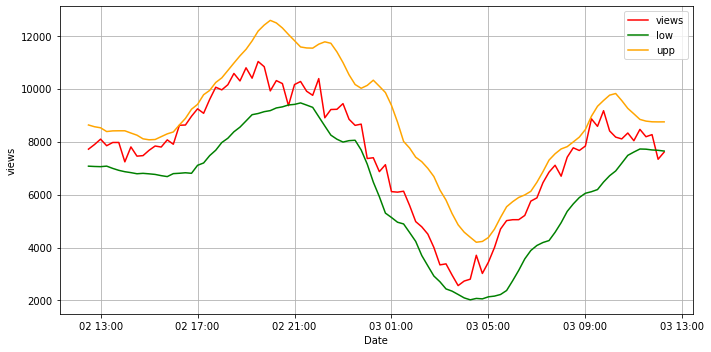

In [13]:
''' 
Нижеприведен код для функции которая считает границы для метрики немного иначе чем в DAG. 
В коде даны пояснения, но самое основное, это то, что для расчета границ я пробую взять не 
только данные сегодняшнего дня, но и в этот же период вчерашние - и усредняю их. Так я хочу
получить данные более точные и более плавные. Но в реальности недостатки самого принципа такой схемы
на мой взгляд остались, поскольку если данные начинают меняться чуть быстрее (c большим градиентом) - то
выход за границы происходит при любой схеме. Но все же этот вариант делает расчет более точным и плавным
поскольку значений для расчета больше - и они включают текущие и вчерашние данные, можно тестировать с
коэффициентом и подобрать что-то оптимальное.
'''
metrics = df_like_view.columns.to_list()[1:] # Создаем список метрик из столбцов кроме первого(индекс)
day_int = 96 # Количество 15ти минутных интервалов в сутках 24*4

n = 5 # Размер скользящего окна - количество предыдущих показаний метрики для расчета границ
coef = 1.2 # Коэффициент для межквартильного размаха
for metric in metrics: # Цикл для каждой метрики
    df = df_like_view.copy() # Делаем копию исходных данных
    df = df[['time', metric]].reset_index(drop=True) # Оставляем столбик времени и метрики
    df['low'] = np.nan # Создаем столбик для верхней границы и заполняем Nan
    df['upp'] = np.nan # Создаем столбик для верхней границы и заполняем Nan
    ''' Сделаем индексы нужных нам данных из датафрейма, таким образом, чтобы график рисовал нам последние
    сутки, т.е. 96 интервалов по 15мин - назад. Мы вычитаем из длины нашего df 96 и получаем начало отсчета 
    и конец это последнее значение в df, а все остальные занчения нужны для расчета границ.
    Границы мы берем так: за сегодня - это текущий индекс минус n значений без учета текущего, и 
    плюсом (через канкатенацию), вчерашние данные т.е. текущее значение минус 96 + n + 1 (на 1 значени больше
    для точности) - но текущее (вчерашнее берем в расчет) 
    Мы получим данные метрики за вчера в этот же период и за сегодня n периодов назад - это база для 
    расчета границ'''
    for i in range(len(df) - day_int, len(df)): 
        start_corrent = i - n # Стартовый индекс текущего дня -  т.е. n предыдущих значений
        windows_carrent = df.loc[start_corrent : i] # Данные текущего дня 
        start_prev = i - day_int - n - 1 # Стартовый индекс для вчерашнего дня
        windows_prev = df.iloc[start_prev : (i - day_int) + 1] # Данные за вчера включая текущее значение
        windows = pd.concat([windows_carrent, windows_prev]) # Соединяем наши таблички
        q25 = windows[metric].quantile(0.25) # Считаем квантили 
        q75 = windows[metric].quantile(0.75) # Считаем квантили 
        IQR = q75 - q25 # Считаем размах
        low = q25 - IQR*coef # Считаем границу верх
        upp = q75 + IQR*coef # Считаем границу низ
        # Создаем столбцы с границами через присвоение значений в ячейки(столбцы уже созданы ранее)
        df.at[i, 'low'] = low # Точечно присваивает значения в конкретную ячейку
        df.at[i, 'upp'] = upp # по метке строки (i) и названию столбца 'upp'
    df = df.iloc[len(df) - day_int:] # Осталяем токлько последние сутки
    # Переопределяем наши границы проходя скользящим окном и усредняя значения (окно с центральным положением - 
    # это значит что окно берет данные как предыдущие так и последующие)
    df['low'] = df['low'].rolling(window=n, center=True, min_periods=1).mean()
    df['upp'] = df['upp'].rolling(window=n, center=True, min_periods=1).mean()   
    carrent_value = df[metric].iloc[-1] # Текущее значение метрики
    low_value = df['low'].iloc[-1] # Текущее значение нижней границы
    upp_value = df['upp'].iloc[-1] # Текущее значение верхней границы
    # Проверяем выходит ли текущее значение за границы - елсли да то формируем график и сообщение
    if carrent_value < low_value or carrent_value > upp_value:
        if carrent_value < low_value:
            dif = low_value - carrent_value
            print(f'Метрика {metric} = {carrent_value:.1f},\n'\
            f'ниже нижней границы low_value = {low_value:.1f} на {dif:.1f}')
            plt.figure(figsize=(10, 5))
            plt.plot(df['time'], df[metric], label=f'{metric}', color='red')
            plt.plot(df['time'], df['low'], label='low', color='green')
            plt.plot(df['time'], df['upp'], label='upp', color='orange')
            ax = plt.gca()
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
            plt.xlabel('Date')
            plt.ylabel(f'{metric}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            dif = carrent_value - upp_value
            print(f'Метрика {metric:.1f} = {carrent_value:.1f},\n'\
                  f'выше верхней границы  upp_value = {upp_value:.1f} на {dif:.1f}')
            plt.figure(figsize=(10, 5))
            plt.plot(df['time'], df[metric], label=f'{metric}', color='red')
            plt.plot(df['time'], df['low'], label='low', color='green')
            plt.plot(df['time'], df['upp'], label='upp', color='orange')
            ax = plt.gca()
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
            plt.xlabel('Date')
            plt.ylabel(f'{metric}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

In [11]:
'''Сравним работу функции с обычным подсчетом границ из n периодов назад (данные только за сегодня)
при коэффициенте 2 и визуально можно сравнить график,с графиком выше где коэффициент 1.2'''
def alert_feed(df_like_view, n, coef):
    metrics = df_like_view.columns.to_list()[1:]
    
    for metric in metrics:
        df_metric = df_like_view[['time', metric]].copy()
        df_metric['q25'] = df_metric[metric].shift(1).rolling(window=n, min_periods=1).quantile(0.25)
        df_metric['q75'] = df_metric[metric].shift(1).rolling(window=n, min_periods=1).quantile(0.75)
        df_metric['iqr'] = df_metric['q75'] - df_metric['q25']
        df_metric['low'] = df_metric['q25'] - df_metric['iqr']*coef
        df_metric['upp'] = df_metric['q75'] + df_metric['iqr']*coef
        df_metric['low'] = df_metric['low'].rolling(window=n, min_periods=1).median()
        df_metric['upp'] = df_metric['upp'].rolling(window=n, min_periods=1).median()
        metric_now = df_metric[metric].iloc[-1]
        low_now = df_metric['low'].iloc[-1]
        upp_now = df_metric['upp'].iloc[-1]
        if metric_now < low_now or metric_now > upp_now:
            if metric_now < low_now:
                dif = low_now - metric_now
                message = (f'Метрика {metric}={metric_now} ниже нижней границы {low_now:.1f}, на {dif}\n'
                           f'Ссылка - https://superset.lab.karpov.courses/superset/dashboard/6633/')  
                print(message)
                plt.figure(figsize=(11, 6))

                plt.plot(df_metric['time'], df_metric[metric], label=f'{metric}', color='red')
                plt.plot(df_metric['time'], df_metric['low'], label='Low', color='green')
                plt.plot(df_metric['time'], df_metric['upp'], label='Upp', color='orange')
                ax = plt.gca()
                ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %H:%M"))
                ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
                plt.title(f'{metric} and IQR')
                plt.xlabel('Date')
                plt.ylabel('Value')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()

                
            else:
                dif = metric_now - upp_now
                message = (f'Метрика {metric}={metric_now} выше верхней границы {upp_now:.1f}, на {dif}\n'
                           f'Ссылка - https://superset.lab.karpov.courses/superset/dashboard/6633/')      
                print(message)
                plt.figure(figsize=(11, 6))

                plt.plot(df_metric['time'], df_metric[metric], label=f'{metric}', color='red')
                plt.plot(df_metric['time'], df_metric['low'], label='Low', color='green')
                plt.plot(df_metric['time'], df_metric['upp'], label='Upp', color='orange')
                ax = plt.gca()
                ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %H:%M"))
                ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))
                plt.title(f'{metric} and IQR')
                plt.xlabel('Date')
                plt.ylabel('Value')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()       
            

Метрика views=7606 ниже нижней границы 7690.4, на 84.39999999999964
Ссылка - https://superset.lab.karpov.courses/superset/dashboard/6633/
Метрика likes=1560 ниже нижней границы 1621.2, на 61.200000000000045
Ссылка - https://superset.lab.karpov.courses/superset/dashboard/6633/


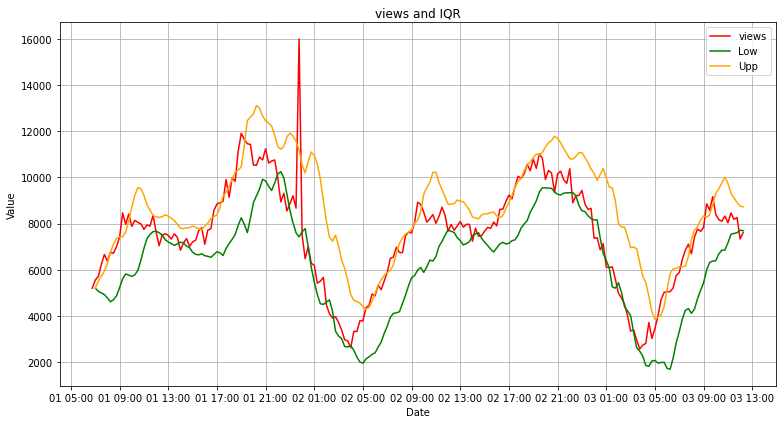

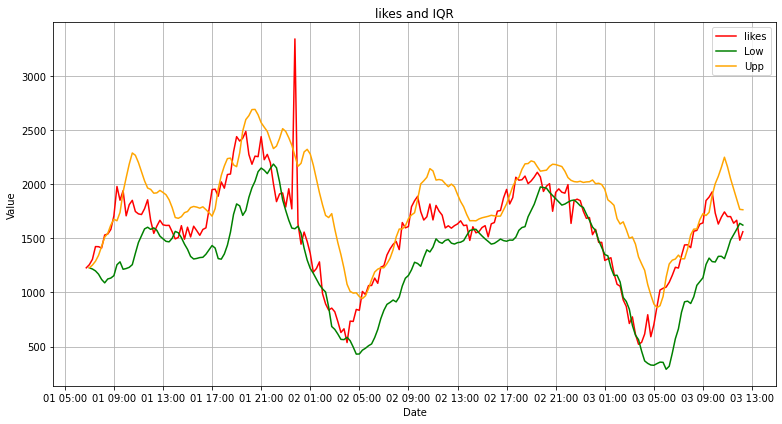

In [12]:
alert_feed(df_like_view, n=5, coef=2)

In [66]:
'''
Как видно система включающая данные за сегодня и вчера работает более точнее, метрика менее часто выходит 
за границы на коэффициенте 1.2, в вто время как метрика на обычном подсчете, сегодняшних значений для границ, 
на коэффициенте 2.0 постоянно выходит за эти границы.'''